In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [144]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [31]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [32]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect = True)

# reflect the tables

In [33]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [34]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [35]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [36]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results



# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [44]:
# See Max Data
max_date = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).limit(5).all()
max_date[0][0]

# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data, columns = ['date', 'precipitation'])

#set index
precipitation_df.set_index('date', inplace = True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date')
precipitation_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


In [53]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [57]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.id).count()
stations

9

In [58]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [60]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = 'USC00519281'
temperatures = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
temperatures

[(54.0, 85.0, 71.66378066378067)]

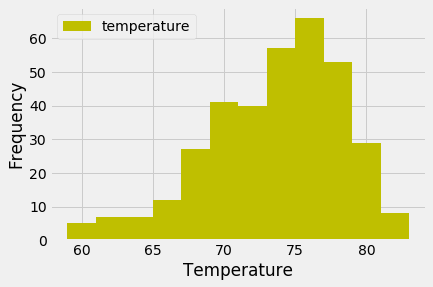

In [73]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_observation = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

temperature_observation_df = pd.DataFrame(temperature_observation, columns = ['date', 'temperature'])

#Plotting
fig, ax = plt.subplots()
#12 months
temperature_observation_df.plot.hist(bins = 12, ax = ax, color = 'y')
ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')
plt.show()


## Bonus Challenge Assignment

In [74]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [76]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2016-12-26','2017-01-03')
trip_temps

[(62.0, 70.54545454545455, 77.0)]

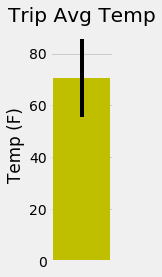

In [88]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_temp = trip_temps[0][0]
avg_temp = trip_temps[0][1]
max_temp = trip_temps[0][2]

min_error = avg_temp - min_temp
max_error = max_temp - avg_temp

plt.figure(figsize=(1,4))
plt.bar(0, avg_temp, yerr=[max_temp-min_temp], color = 'y')
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.xticks([])

plt.show()

In [111]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2016-12-26'
end_date = '2017-01-03'

s = session.query(Station.station,
                  func.sum(Measurement.prcp),
                  Station.name,
                  Station.elevation,                                    
                  Station.latitude,
                  Station.longitude)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= start_date)\
.filter(Measurement.date <= end_date)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc())

for row in s:
    print (f"Station:  {row[0]}\n    Rainfall:  {rain}  \n    Location:  {row[2]}\n    Elevation:  {row[3]}\n    Latitude:  {row[4]}\n    Longitude:  {row[5]}")
    print()

Station:  USC00516128
    Rainfall:  0.21  
    Location:  MANOA LYON ARBO 785.2, HI US
    Elevation:  152.4
    Latitude:  21.3331
    Longitude:  -157.8025

Station:  USC00513117
    Rainfall:  0.21  
    Location:  KANEOHE 838.1, HI US
    Elevation:  14.6
    Latitude:  21.4234
    Longitude:  -157.8015

Station:  USC00519281
    Rainfall:  0.21  
    Location:  WAIHEE 837.5, HI US
    Elevation:  32.9
    Latitude:  21.45167
    Longitude:  -157.84888999999998

Station:  USC00514830
    Rainfall:  0.21  
    Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US
    Elevation:  7.0
    Latitude:  21.5213
    Longitude:  -157.8374

Station:  USC00519523
    Rainfall:  0.21  
    Location:  WAIMANALO EXPERIMENTAL FARM, HI US
    Elevation:  19.5
    Latitude:  21.33556
    Longitude:  -157.71139

Station:  USC00519397
    Rainfall:  0.21  
    Location:  WAIKIKI 717.2, HI US
    Elevation:  3.0
    Latitude:  21.2716
    Longitude:  -157.8168

Station:  USC00517948
    Rainfall:  0.21  

In [197]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [208]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

#set the start and end date for the trip
start_date = '2016-12-26'
end_date = '2017-01-03'

#calculate trip length
startNum = int(start_date[-2:])
endNum = int(end_date[-2:])
tripLength = endNum + (31 - startNum) + 1

#start date as datetime object
start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')
#list dates (MM-DD) of trip
dateList = [dt.datetime.strftime(start_date + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, tripLength)]

#Loop through the list of %m-%d strings and calculate the normals for each date
tripNormals = [daily_normals(date) for date in dateList]

tripNormals



[[(63.0, 71.44680851063829, 77.0)],
 [(62.0, 71.91666666666667, 79.0)],
 [(62.0, 70.52083333333333, 77.0)],
 [(57.0, 70.29166666666667, 78.0)],
 [(63.0, 69.86363636363636, 76.0)],
 [(56.0, 68.27906976744185, 77.0)],
 [(62.0, 69.15384615384616, 77.0)],
 [(60.0, 69.39622641509433, 77.0)],
 [(62.0, 68.9090909090909, 77.0)]]

In [209]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
#extract normals into a list of lists
tripNormals = [np.array(normal[0]) for normal in tripNormals]

#convert normals list into a data frame
normalsTable = pd.DataFrame(tripNormals)
#add date column
normalsTable["Date"] = dateList
#set index and rename columns
normalsTable = normalsTable.set_index("Date")
normalsTable = normalsTable.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})

normalsTable

,Low Temp,Avg Temp,High Temp
Date,,,
12-26,63.0,71.446809,77.0
12-27,62.0,71.916667,79.0
12-28,62.0,70.520833,77.0
12-29,57.0,70.291667,78.0
12-30,63.0,69.863636,76.0
12-31,56.0,68.279070,77.0
01-01,62.0,69.153846,77.0
01-02,60.0,69.396226,77.0
01-03,62.0,68.909091,77.0


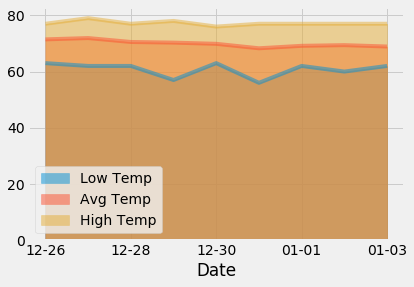

In [213]:
# Plot the daily normals as an area plot with `stacked=False`
#plot with pandas
normalsTable.plot.area(stacked=False)